In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
!pip install pretrainedmodels
!git clone https://github.com/Cadene/pretrained-models.pytorch.git

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
fatal: destination path 'pretrained-models.pytorch' already exists and is not an empty directory.


In [15]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from albumentations import (Flip,Rotate,Compose,RandomBrightness,GaussNoise,HorizontalFlip)
import glob
import random
from sklearn.model_selection import train_test_split
import pretrainedmodels
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [16]:
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet,self).__init__()
    self.conv1=nn.Conv2d(3,6,7)
    self.conv2=nn.Conv2d(6,16,7)
    self.poo1=nn.MaxPool2d(2)
    self.pool2=nn.MaxPool2d(2)
    self.fc1=nn.Linear( 41616,200)
    self.fc2=nn.Linear(200,84)
    self.fc3=nn.Linear(84,3)

  def forward(self,x):
    x=self.poo1(F.relu(self.conv1(x),2))
    x=self.pool2(F.relu(self.conv2(x),2))
    x=x.view(x.shape[0],-1)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x

In [17]:
import imageio

class Kaggle_Cancer(Dataset):
  def __init__(self, root_path, transforms=None,preprocessing=None,resize=216):
    self.path = root_path
    self.transforms=transforms
    self.preprocessing=preprocessing
    self.resize=resize

  def __len__(self):
      return len(self.path)
  

  def __getitem__(self, idx):
    p=self.path[idx]
    image1=cv2.imread(p)
    label=p.split("/")[-2].split("_")[-1]
    image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    if self.transforms:
      image1=self.transforms(image=image1)['image']
    image1 = np.transpose(image1, (2,1,0))
    image1=torch.from_numpy(image1)
    return image1,int(label)

In [18]:
resnet50 = pretrainedmodels.__dict__["resnet50"](num_classes=1000, pretrained='imagenet')
resnet50.last_linear=torch.nn.Linear(in_features=2048,out_features=3, bias=True)
lenet = LeNet()
resnext=models.resnext50_32x4d()
resnext.fc=torch.nn.Linear(in_features=2048,out_features=3, bias=True)

In [19]:

path_train=glob.glob("/kaggle/input/train1/train/train/*/*")
random.shuffle(path_train)
temp=[0]*len(path_train)
XTrain, xVal, _, _ = train_test_split(path_train,temp, test_size = 0.05, random_state = 0)
transforms=Compose([Rotate(p=0.4,limit=30),RandomBrightness(p=0.8),GaussNoise(p=0.2),HorizontalFlip(p=0.4)])

#define our dataset using our class
dataset = Kaggle_Cancer(XTrain,transforms=transforms)
training_set=DataLoader(dataset,batch_size=64,shuffle=True)

val_set = Kaggle_Cancer(xVal)
val_loader=DataLoader(val_set,batch_size=64)

In [20]:
from tqdm import tqdm, notebook


def train(epoch_number,model,optim,loss):
  model.train()
  all_loss=0
  correct=0
  tqdm_loader=tqdm(training_set)
  for  index,(img,target) in enumerate(tqdm_loader):
    img=img.float().cuda()
    target=target.long().cuda()

    optim.zero_grad()
    out=model(img)
    loss1=loss(out,target)
    loss1.backward()
    optim.step()
    all_loss+=loss1.item()
    avg_loss=all_loss/(index+1)
    pred=out.argmax(dim=1,keepdim=True)
    correct+=pred.eq(target.view_as(pred)).sum().item()/len(target)

    avg_acc=correct/(index+1)
    tqdm_loader.set_description("Epoch {} train loss={:4}  acc={:4} ".format(epoch_number,round(avg_loss,4),round(avg_acc,4)))
  
  return avg_loss,avg_acc


def validation(epoch_number,model,loss):
  model.eval()
  all_loss=0
  correct=0
  tqdm_loader=tqdm(val_loader)
  for index,(img,target) in enumerate(tqdm_loader):
    img=img.float().cuda()
    target=target.long().cuda()

    with torch.no_grad():
      out=model(img)
      loss1=loss(out,target)

    all_loss+=loss1.item()
    avg_loss=all_loss/(index+1)

    pred=out.argmax(dim=1,keepdim=True)
    correct+=pred.eq(target.view_as(pred)).sum().item()/len(target)
    avg_acc=correct/(index+1)

    tqdm_loader.set_description("Epoch {} validation loss={:4}  acc={:4} ".format(epoch_number,round(avg_loss,4),round(avg_acc,4)))

  return avg_loss,avg_acc

Epoch 19 validation loss=1.0245  acc=0.5227 : 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


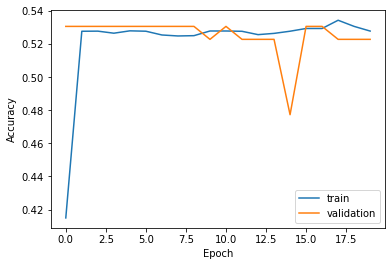

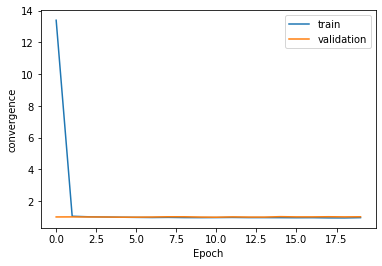

Epoch 19 validation loss=1.7134  acc=0.4744 : 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


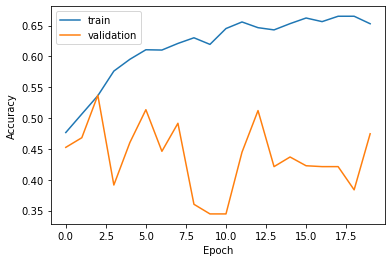

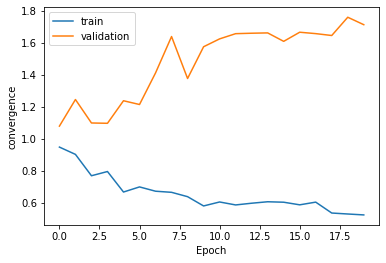

Epoch 19 validation loss=1.137  acc=0.3054 : 100%|██████████| 2/2 [00:00<00:00,  5.12it/s] 


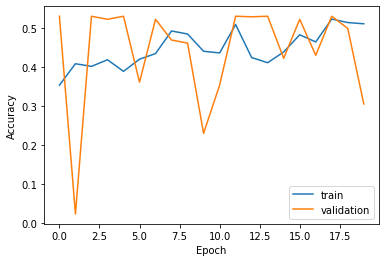

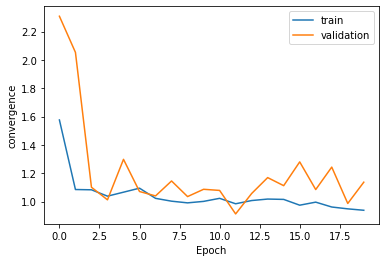

In [21]:
list_model=[lenet,resnet50,resnext]
epcoh_number=20
for model in list_model:
    list_epoch=[]
    l1,l2=0,0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    loss_cross=torch.nn.CrossEntropyLoss()
    if model==resnet50:
        adam=torch.optim.Adam(model.parameters(),lr=0.0001)
    else:
        adam=torch.optim.Adam(model.parameters())
    loss_train={"avg_loss":[],"accuracy":[]}
    loss_val={"avg_loss":[],"accuracy":[]}
    for epoch in range(epcoh_number):
        list_epoch.append(epoch)
        l1,l2=train(epoch,model,adam,loss_cross)
        loss_train["avg_loss"].append(l1)
        loss_train["accuracy"].append(l2)
        l1,l2=validation(epoch,model,loss_cross)
        loss_val["avg_loss"].append(l1)
        loss_val["accuracy"].append(l2)
    plt.plot(list_epoch,loss_train["accuracy"],label="train")
    plt.plot(list_epoch,loss_val["accuracy"],label="validation")
    # naming the x axis 
    plt.xlabel('Epoch') 
    # naming the y axis 
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(list_epoch,loss_train["avg_loss"],label="train")
    plt.plot(list_epoch,loss_val["avg_loss"],label="validation")
    plt.xlabel('Epoch') 
    # naming the y axis 
    plt.ylabel('convergence')
    plt.legend()
    plt.show()
    

In [22]:
class ensemble(nn.Module):
    def __init__(self,model,w):
        super(ensemble,self).__init__()
        self.models=model
        self.w=w
    def __call__(self,x):
        result=[]
        for w1,m1 in zip(self.w,self.models):
            with torch.no_grad():
                y=w1*m1(x)
                y=F.softmax(y,dim=1)
                result.append(y.cpu().numpy())
        result=np.array(result)
        return result.mean(axis=0)
        #torch.from_numpy(result.mean(axis=0)).float().to(device)

In [23]:

w=[0.3,0.4,0.3]
ensemble_model=ensemble(list_model,w)

In [26]:

list_file=glob.glob('/kaggle/input/test224/test_stg2/*')
sample_subm = pd.read_csv("/kaggle/input/intel-mobileodt-cervical-cancer-screening/sample_submission_stg2.csv")
y_test=[]
for i in range(len(list_file)):
    image1=cv2.imread(list_file[i])
    image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image1 = np.transpose(image1, (2,1,0))
    image1=np.expand_dims(image1, axis=0)
    image1=torch.from_numpy(image1)
    image1=image1.float().cuda()
    y_test=ensemble_model(image1)
    id=list_file[i].split("/")[-1]
    for j in range(3):
        sample_subm.loc[sample_subm['image_name'] == id, 'Type_1'] = y_test[0,0]
        sample_subm.loc[sample_subm['image_name'] == id, 'Type_2'] = y_test[0,1]
        sample_subm.loc[sample_subm['image_name'] == id, 'Type_3'] = y_test[0,2]
        
list_file=glob.glob("/kaggle/input/intel-mobileodt-cervical-cancer-screening/test/test/*")
for i in range(len(list_file)):
    image1=cv2.imread(list_file[i])
    image1=cv2.resize(image1,(224,224))
    image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image1 = np.transpose(image1, (2,1,0))
    image1=np.expand_dims(image1, axis=0)
    image1=torch.from_numpy(image1)
    image1=image1.float().cuda()
    y_test=ensemble_model(image1)
    id=list_file[i].split("/")[-1]
    for j in range(3):
        sample_subm.loc[sample_subm['image_name'] == id, 'Type_1'] = y_test[0,0]
        sample_subm.loc[sample_subm['image_name'] == id, 'Type_2'] = y_test[0,1]
        sample_subm.loc[sample_subm['image_name'] == id, 'Type_3'] = y_test[0,2]
sample_subm.to_csv("submissionCancer.csv", index=False)

RuntimeError: size mismatch, m1: [1 x 12636208], m2: [41616 x 200] at /opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/THC/generic/THCTensorMathBlas.cu:283